In [1]:
# Basics
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# TensorFlow/Keras (Keras layers below)
from tensorflow.keras.utils import to_categorical

# Custom
import sys
sys.path.insert(0, '/home/lcastellazzi/MDM32/src/utils')
from preprocessing import TraceHandler
from nicv import nicv
import constants
from postprocessing import Evaluator


# Suppress TensorFlow messages
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' # 1 for INFO, 2 for INFO & WARNINGs, 3 for INFO & WARNINGs & ERRORs

In [2]:
paths = {'train': '/prj/side_channel/PinataTraces/CURR/D1-K1_50k_500MHz + Resampled at 168MHz.trs', # D1_K1
         'test' : '/prj/side_channel/PinataTraces/CURR/D1-K2_50k_500MHz + Resampled at 168MHz.trs'} # D1_K2

trace_handlers = {key: TraceHandler(path) for key, path in paths.items()}

Labeling traces: 100%|██████████| 50000/50000 [00:01<00:00, 25506.77it/s]


In [3]:
BYTE_IDX = 0
VAL_PERC = 0.1
N_CLASSES = 256

x_train, x_val, y_train, y_val = trace_handlers['train'].generate_train_val(BYTE_IDX, val_perc=VAL_PERC) 
x_test, y_test = trace_handlers['test'].generate_test(BYTE_IDX) 

y_train_cat = to_categorical(y_train, N_CLASSES)
y_val_cat = to_categorical(y_val, N_CLASSES)
y_test_cat = to_categorical(y_test, N_CLASSES)

In [4]:
# MLP from Mind the Portability (code from authors - mlp_no_portability.py)

# LAYER_LIST = [4] # List for grid-search
# NEURON_LIST = [500, 600, 700] # List for grid-search
# NUM_FEATURES = len(x_train[0]) # 1237
# BATCH_SIZE = 256
# NUM_EPOCHS = 20
# LOSS_FUNCTION = 'categorical_crossentropy'
# LR = 1e-4
# OPTIMIZER = RMSprop(learning_rate=LR)

# validation_scores = np.zeros((len(LAYER_LIST), len(NEURON_LIST)))
# all_test_predictions = np.zeros((len(LAYER_LIST),
#                                  len(NEURON_LIST), 
#                                  y_test_cat.shape[0], 
#                                  N_CLASSES))

# print(f'Epochs: {NUM_EPOCHS}, batch size: {BATCH_SIZE}, loss: {LOSS_FUNCTION}, optimizer: {OPTIMIZER}')
# print('Starting grid search.')

# for layer_idx, layer_num in enumerate(LAYER_LIST):
#     for neurons_idx, neurons_num in enumerate(NEURON_LIST):
        
#         model = Sequential()
        
#         # First hidden layer, with explicit input dimensions, ReLu
#         model.add(Dense(neurons_num, 
#                         activation='relu',
#                         input_shape=(NUM_FEATURES, )))
        
#         # Add more hidden layers, ReLu
#         for _ in range(layer_num - 1):
#             model.add(Dense(neurons_num, 
#                             activation='relu'))
        
#         # Output layer: softmax
#         model.add(Dense(N_CLASSES, 
#                         activation='softmax'))
            
#         # Compile, print and train model
#         model.compile(optimizer=OPTIMIZER, 
#                       loss=LOSS_FUNCTION,
#                       metrics=['accuracy'])
#         model.summary()
#         print()
#         print('TRAIN')
#         model.fit(x_train, 
#                   y_train_cat,
#                   validation_data=(x_val, y_val_cat),
#                   epochs=NUM_EPOCHS,
#                   verbose=1)
        
#         # Add accuracy score to table
#         print()
#         print('VAL')
#         validation_scores[layer_idx, neurons_idx] = model.evaluate(x_val, 
#                                                                    y_val_cat, 
#                                                                    batch_size=BATCH_SIZE)[1]
        
#         all_test_predictions[layer_idx, neurons_idx, :, :] = model.predict(x_test)
        
# print()
# print('Accuracy scores for validation set:')
# print(validation_scores)

# best_layer_idx, best_neurons_idx = np.unravel_index(np.argmax(validation_scores), 
#                                                     validation_scores.shape)

# print()
# print(f'Best model has {validation_scores[best_layer_idx, best_neurons_idx]} accuracy on the validation set, using {LAYER_LIST[best_layer_idx]} layers of {NEURON_LIST[best_neurons_idx]} neurons')

# predictions = all_test_predictions[best_layer_idx, best_neurons_idx]

In [108]:
from tensorflow.keras.optimizers import Adam, RMSprop

hp = {'input_size':         len(x_train[0]), # 1237
      'num_hidden_layers':  4,
      'num_hidden_neurons': 600,
      'dropout_rate':       0.3,
      'batch_size':         256,
      'lr':                 1e-4,
      'opt':                RMSprop}

In [109]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization

LOSS = 'categorical_crossentropy'

############################################################
# Init model
model = Sequential()

# Input
model.add(Dense(hp['input_size'], activation='relu'))

# Batch Normalization
model.add(BatchNormalization())

# Hidden
for _ in range(hp['num_hidden_layers']):
    model.add(Dense(hp['num_hidden_neurons'], activation='relu'))

    # Dropout
    model.add(Dropout(hp['dropout_rate']))

# Batch Normalization
model.add(BatchNormalization())
    
# Output
model.add(Dense(N_CLASSES, activation='softmax'))
############################################################

model.compile(optimizer=hp['opt'](learning_rate=hp['lr']),
              loss=LOSS,
              metrics=['accuracy'])

# model.summary()

In [110]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='loss', patience=5)

In [111]:
NUM_EPOCHS = 100

history = model.fit(x_train, 
                    y_train_cat,
                    validation_data=(x_val, y_val_cat),
                    epochs=NUM_EPOCHS,
                    batch_size=hp['batch_size'],
                    callbacks=[es],
                    verbose=1)

Epoch 1/100
176/176 [==============================] - 1s 4ms/step - loss: 6.1555 - accuracy: 0.0045 - val_loss: 5.5958 - val_accuracy: 0.0068
Epoch 2/100
176/176 [==============================] - 1s 3ms/step - loss: 5.9051 - accuracy: 0.0080 - val_loss: 5.3572 - val_accuracy: 0.0086
Epoch 3/100
176/176 [==============================] - 1s 3ms/step - loss: 5.6163 - accuracy: 0.0096 - val_loss: 5.3486 - val_accuracy: 0.0098
Epoch 4/100
176/176 [==============================] - 1s 3ms/step - loss: 5.4160 - accuracy: 0.0128 - val_loss: 5.2900 - val_accuracy: 0.0142
Epoch 5/100
176/176 [==============================] - 1s 4ms/step - loss: 5.2369 - accuracy: 0.0171 - val_loss: 4.9829 - val_accuracy: 0.0256
Epoch 6/100
176/176 [==============================] - 1s 3ms/step - loss: 5.0436 - accuracy: 0.0242 - val_loss: 4.8806 - val_accuracy: 0.0280
Epoch 7/100
176/176 [==============================] - 1s 3ms/step - loss: 4.8908 - accuracy: 0.0284 - val_loss: 4.6407 - val_accuracy: 0.0356

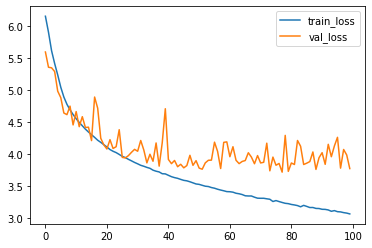

In [112]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

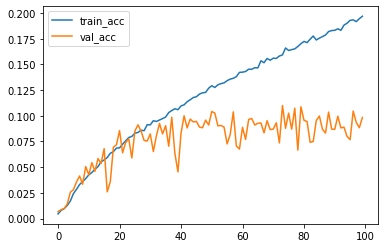

In [113]:
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [ ]:
label_probs = model.predict(x_test)

In [ ]:
plaintexts = trace_handlers['test'].get_plaintexts()
true_key_byte = constants.KEYS['K2'][BYTE_IDX]

evaluator = Evaluator(label_probs, plaintexts, BYTE_IDX)
ranking = evaluator.rank_key_bytes()
true_key_byte_rank = evaluator.get_true_key_byte_rank(ranking, true_key_byte)

true_key_byte_rank

Computing final key-byte probabilities: 100%|██████████| 50000/50000 [00:24<00:00, 2058.47it/s]


2

In [103]:
list(ranking.items())[:5]

[('ab', -177665.09206699894),
 ('a9', -177667.19578144667),
 ('5d', -177886.94332806085),
 ('bb', -177961.8678353351),
 ('39', -178250.85306734117)]